In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

In [2]:
import numpy as np 
import scipy.fft
from operators.SW_sqrt import solve_poisson_equation, psi_ln_sw, mass, momentum, energy_k

In [3]:
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'serif',
        'size'   : 14}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

# Linear Landau Damping SW square-root

In [4]:
# set up configuration parameters
# number of mesh points in x 
Nx = 101
# number of spectral expansions
Nv = 100
# epsilon displacement in initial electron distribution 
epsilon = 1e-2
# velocity scaling of electron and ion
alpha_e = np.sqrt(2)
alpha_i = np.sqrt(2/1863)
# x grid is from 0 to L
L = 2 * np.pi
# spacial spacing dx = x[i+1] - x[i]
dx = L/(Nx-1)
# time stepping 
dt = 1e-2
# final time 
T = 10.
# velocity scaling 
u_e = 0
u_i = 0 
# mass normalized
m_e = 1
m_i = 1863
# charge normalized
q_e = -1
q_i = 1

In [5]:
# velocity grid for plotting purposes
v = np.linspace(-3, 3, int(1e5))
# spatial grid 
x = np.linspace(0, L, Nx)

In [6]:
# initial condition of the first expansion coefficient
C_0e = np.sqrt((1+ epsilon * np.cos(x)) / alpha_e)
C_0i = np.sqrt(np.ones(Nx) / alpha_i)

In [7]:
# the distribution function of electrons and protons for plotting purposes
f_0e = np.outer(C_0e, psi_ln_sw((v-u_e)/alpha_e, n=0))
f_0i = np.outer(C_0i, psi_ln_sw((v-u_i)/alpha_i, n=0))

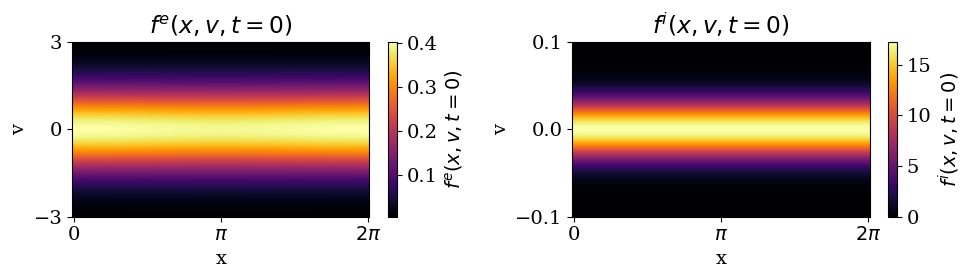

In [8]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 3))
pos = ax[0].pcolormesh(x, v, (f_0e**2).T, cmap="inferno", vmax=np.max(f_0e**2))
ax[0].set_xlabel("x")
ax[0].set_xticks([0, np.pi, 2*np.pi])
ax[0].set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])
ax[0].set_ylabel("v")
ax[0].set_yticks([-3, 0, 3])
cbar = fig.colorbar(pos)

cbar.ax.set_ylabel('$f^{e}(x, v, t=0)$', rotation=90)
ax[0].set_title("$f^{e}(x, v, t=0)$")

pos = ax[1].pcolormesh(x, v, (f_0i**2).T, cmap="inferno")
ax[1].set_xticks([0, np.pi, 2*np.pi])
ax[1].set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])
ax[1].set_ylim(-0.1, 0.1)
ax[1].set_yticks([-0.1, 0, 0.1])
ax[1].set_ylabel("v")
ax[1].set_xlabel("x")
cbar = fig.colorbar(pos)
cbar.ax.set_ylabel('$f^{i}(x, v, t=0)$', rotation=90)
ax[1].set_title("$f^{i}(x, v, t=0)$")
plt.tight_layout()
plt.savefig("../figs/SW_sqrt/linear_landau/initial_condition_landau_damping.png", dpi=600)

In [9]:
sol_midpoint_u = np.load("../data/SW_sqrt/linear_landau/sol_midpoint_u_100.npy")
sol_midpoint_t = np.load("../data/SW_sqrt/linear_landau/sol_midpoint_t_100.npy")

print(np.shape(sol_midpoint_u))
print(np.shape(sol_midpoint_t))

(10002, 1001)
(1001,)


In [10]:
# initialize the electric potential
E_midpoint = np.zeros((Nx-1, len(sol_midpoint_t)))

In [11]:
# initialize the states for implicit midpoint (symplectic)
state_e_midpoint = np.zeros((Nv, Nx-1, len(sol_midpoint_t)))
state_i_midpoint = np.zeros((Nv, Nx-1, len(sol_midpoint_t)))


for ii in range(len(sol_midpoint_t)):
    for jj in range(Nv):
        # unwind the flattening in order to solve the linear system
        state_e_midpoint[jj, :, ii] = sol_midpoint_u[jj*(Nx-1): (jj+1)*(Nx-1), ii]
        state_i_midpoint[0, :, ii] = np.sqrt(np.ones(Nx - 1) / alpha_i)
    
    E_midpoint[:, ii] = solve_poisson_equation(state_e=state_e_midpoint[:, :, ii], 
                                               state_i=state_i_midpoint[:, :, ii], 
                                               alpha_e=alpha_e, 
                                               alpha_i=alpha_i, 
                                               dx=dx, 
                                               solver="gmres", 
                                               order_fd=2, L=L)

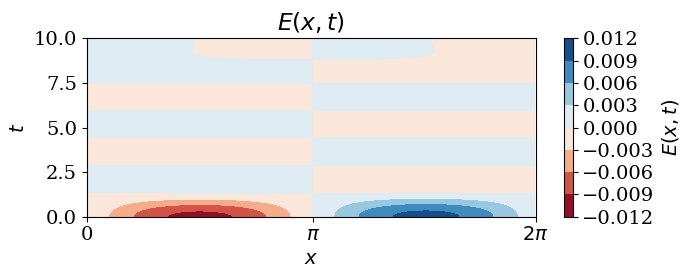

In [12]:
fig, ax = plt.subplots(figsize=(7, 3))
pos = ax.contourf(x[:-1], sol_midpoint_t, E_midpoint.T, cmap="RdBu")
cbar = fig.colorbar(pos)
cbar.ax.set_ylabel("$E(x, t)$", rotation=90)
ax.set_title("$E(x, t)$")
ax.set_xlabel("$x$")
_ = ax.set_xticks([0, np.pi, 2*np.pi-.05])
_ = ax.set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])
_ = ax.set_ylabel("$t$")
plt.tight_layout()

plt.savefig("../figs/SW_sqrt/linear_landau/electric_field_SW_sqrt_" + str(Nv)+ ".png", dpi=600)

In [13]:
np.save("../data/SW_sqrt/linear_landau/sol_midpoint_E_" + str(Nv)+ ".npy", E_midpoint)

In [14]:
E1_midpoint = np.zeros(len(sol_midpoint_t))


for ii in range(len(sol_midpoint_t)):
    E1_midpoint[ii] = np.abs(scipy.fft.fft(E_midpoint[:, ii]))[1]

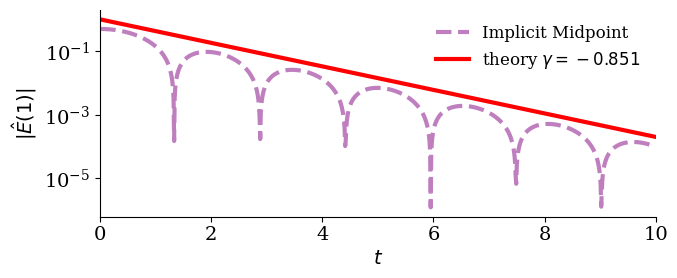

In [15]:
fig, ax = plt.subplots(figsize=(7, 3))
ax.plot(sol_midpoint_t, E1_midpoint, c="purple", ls="--",  alpha=0.5, linewidth=3, label="Implicit Midpoint") 
ax.plot(sol_midpoint_t, np.exp(-0.851*sol_midpoint_t), linewidth=3, color="red", label=r"theory $\gamma = -0.851$") 

ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("$|\hat{E}(1)|$")
ax.set_xlabel("$ t$")
ax.set_xlim(0, T)
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=12, loc='upper right')
legend.get_frame().set_alpha(0)
plt.tight_layout()
plt.savefig("../figs/SW_sqrt/linear_landau/damping_rate_electric_field_" + str(Nv)+ ".png", dpi=600)

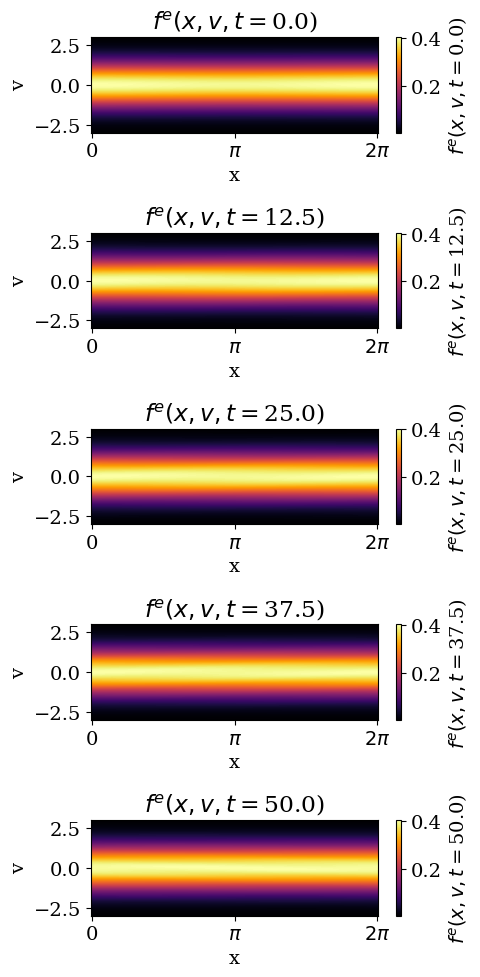

In [16]:
fig, ax = plt.subplots(nrows=5, figsize=(5, 10))
for tt, ii in enumerate(range(0, len(sol_midpoint_t), int(len(sol_midpoint_t)/4))):
    distribution = np.zeros((Nx, len(v)))
    for jj in range(Nv):
        distribution += np.outer(np.append(state_e_midpoint[jj, :, ii], state_e_midpoint[jj, 0, ii]), psi_ln_sw((v)/alpha_e, n=jj))
    pos = ax[tt].pcolormesh(x, v, (distribution**2).T, cmap="inferno")
    ax[tt].set_xlabel("x")
    ax[tt].set_xticks([0, np.pi, 2*np.pi])
    ax[tt].set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])
    ax[tt].set_ylabel("v")
    cbar = fig.colorbar(pos)
    cbar.ax.set_ylabel('$f^{e}(x, v, t=$' + str(round(0.05*ii, 2)) + ")", rotation=90)
    ax[tt].set_title("$f^{e}(x, v, t=$" + str(round(0.05*ii, 2)) + ")")

plt.tight_layout()
plt.savefig("../figs/SW_sqrt/linear_landau/landau_evolution_" +str(Nv)+".png", dpi=600)

# Conservation Laws

### mass conservation

In [17]:
mass_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    mass_midpoint[ii] = mass(state=state_e_midpoint[:, :, ii], alpha_s=alpha_e, dx=dx, Nv=Nv)\
                      + mass(state=state_i_midpoint[:, :, ii], alpha_s=alpha_i, dx=dx, Nv=Nv)

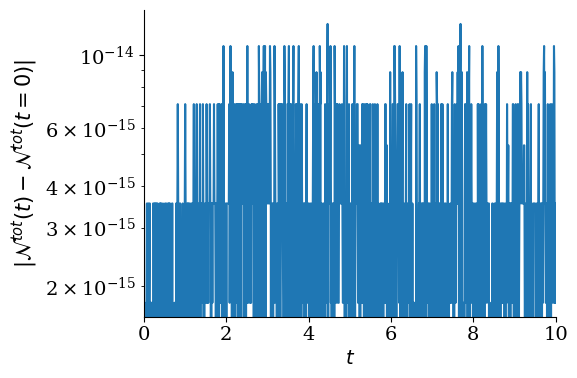

In [18]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(mass_midpoint - mass_midpoint[0]), "-")
ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|\mathcal{N}^{tot}(t) - \mathcal{N}^{tot}(t=0)|$", fontsize=15)
ax.set_xlabel("$t$")
ax.set_xlim(0, T)
plt.tight_layout()

### momentum conservation

In [19]:
momentum_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    momentum_midpoint[ii] = momentum(state=state_e_midpoint[:, :, ii], alpha_s=alpha_e, dx=dx, Nv=Nv, u_s=u_e, m_s=m_e)\
                           +momentum(state=state_i_midpoint[:, :, ii], alpha_s=alpha_i, dx=dx, Nv=Nv, u_s=u_i, m_s=m_i)

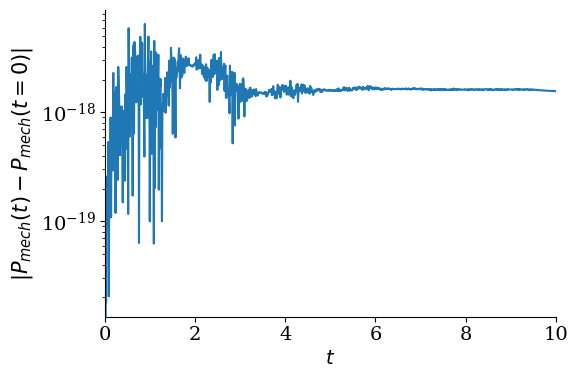

In [20]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(momentum_midpoint - momentum_midpoint[0]), "-")
ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|P_{mech}(t)-P_{mech}(t=0)|$", fontsize=15)
ax.set_xlabel("$ t$")
ax.set_xlim(0, T)
plt.tight_layout()

### Total Energy Conservation

In [21]:
energy_k_midpoint = np.zeros(len(sol_midpoint_t))
energy_p_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    energy_k_midpoint[ii] = energy_k(state=state_e_midpoint[:, :, ii], Nv=Nv, alpha_s=alpha_e, m_s=m_e, dx=dx, u_s=u_e)\
                           +energy_k(state=state_i_midpoint[:, :, ii], Nv=Nv, alpha_s=alpha_i, m_s=m_i, dx=dx, u_s=u_i)
    
    energy_p_midpoint[ii] = 0.5*dx*np.sum((E_midpoint[:, ii])**2)

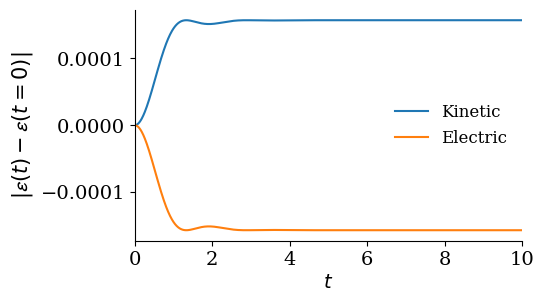

In [22]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(sol_midpoint_t, energy_k_midpoint - energy_k_midpoint[0] - sol_midpoint_u[-1, :], label="Kinetic")
ax.plot(sol_midpoint_t, energy_p_midpoint - energy_p_midpoint[0], label="Electric")
ax.set_ylabel(r"$|\mathcal{\epsilon}(t)-\mathcal{\epsilon}(t=0)|$", fontsize=15)
ax.set_xlabel("$t$")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim(0, 10)
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=12)
legend.get_frame().set_alpha(0)
plt.savefig("../figs/SW_sqrt/linear_landau/energy_transfer.png", dpi=600)

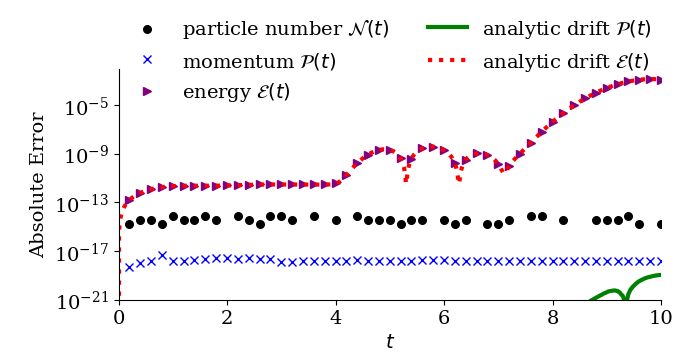

In [25]:
fig, ax = plt.subplots(ncols=1, figsize=(7, 3))

ax.scatter(sol_midpoint_t[::20], np.abs(mass_midpoint-mass_midpoint[0])[::20], s=30, color="black", label=r"particle number $\mathcal{N}(t)$")
ax.plot(sol_midpoint_t[::20], np.abs(momentum_midpoint-momentum_midpoint[0])[::20], "x", color="blue", label=r"momentum $\mathcal{P}(t)$")
ax.plot(sol_midpoint_t[::20], np.abs(energy_p_midpoint + energy_k_midpoint -energy_p_midpoint[0]-energy_k_midpoint[0])[::20], ">", color="purple", label=r"energy $\mathcal{E}(t)$")
ax.plot(sol_midpoint_t, np.abs(sol_midpoint_u[-2]), "-", c="green", linewidth=3, label=r"analytic drift $\mathcal{P}(t)$")
ax.plot(sol_midpoint_t, np.abs(sol_midpoint_u[-1]), ":", c="red", linewidth=3, label=r"analytic drift $\mathcal{E}(t)$")

ax.set_ylim(10**-21, 10**-2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"Absolute Error")
ax.set_xlabel("$t$")
ax.set_xlim(0, T)
ax.set_yscale("log")
legend = ax.legend(ncols=2, fontsize=14, loc='upper center', bbox_to_anchor=(0.5, 1.3))
text = ax.text(-0.2,1.05, " ", transform=ax.transAxes)
legend.get_frame().set_alpha(0)
plt.savefig("../figs/SW_sqrt/linear_landau/conservation_" + str(Nv) + "_linear_landau_SW_sqrt.png", bbox_extra_artists=(legend,text), bbox_inches='tight', dpi=600)